In [1]:
import numpy as np
import tensorflow as tf
from get_data import get_memristor_data
try: 
    from itertools import izip
except:
    izip = zip
    
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm
    
import os
if not os.path.exists('tmp/'):
    os.makedirs('tmp/')

In [2]:
def gauss_interp(samp, xs, ys, interp_width, ratio=0.75):
    """
    Parameters
    ----------
    samp : tf.tensor (batch_size, n_m)
    xs : tf.tensor (n_p, n_m)
        Grid inputs
    ys : tf.tensor (n_p, n_m)
        Grid outputs
    interp_width : float
        Spacing between the xs
    Returns
    -------
    interp_func : tf.tensor (batch_size, n_m)
    """
    samp = tf.expand_dims(samp, 1)  # (batch, 1, n_m)
    xs = tf.cast(tf.expand_dims(xs, 0), tf.float32)  # (1, n_p, n_m)
    ys = tf.cast(tf.expand_dims(ys, 0), tf.float32)  # (1, n_p, n_m)
    sig = np.float32(ratio * interp_width)  # spacing of xs
    norm_factor = np.sqrt(2 * np.pi) * sig / interp_width
    norm_factor = np.array(norm_factor, dtype='float32')
    return tf.reduce_sum(ys * tf.exp( -0.5 * (samp - xs) ** 2 / sig ** 2) /
                         norm_factor,
                  reduction_indices=1)

In [3]:
def memristor_output(v, eps, vs, mus, sigs, interp_width):
    """
    Parameters
    ----------
    mu, sig, eps : tf.tensor (batch_size, n_m)
        mean, standard deviation, noise
    """
    mean = gauss_interp(v, vs, mus, interp_width)
    sdev = gauss_interp(v, vs, sigs, interp_width)
    return mean + eps * sdev

In [4]:
def _train_graph(
    graph,
    init_op,
    train_op,
    cost_op, # FIXME unused
    summary_dict,
    saver,
    train_data_object,
    summary_data_object,
    feed_vars,
    batch_size,
    num_epochs,
    param_file,
    checkpoint_every_n_epochs,
    global_step,
    save_path='tmp/model.ckpt'
):
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

    inc_global_step = tf.assign(global_step, global_step + 1)
    with tf.Session(graph=graph, config=config) as sess:
        sess.run(init_op) if param_file is None else saver.restore(sess, param_file)
        for j in range(num_epochs):
            sess.run(inc_global_step)
            train_data_generator = train_data_object.get_generator(batch_size)
            for feed_values in train_data_generator:
                sess.run(
                    train_op,
                    feed_dict=dict(zip(feed_vars, feed_values))
                )

            summary_data_generator = summary_data_object.get_generator()
            for feed_values in summary_data_generator:
                summary_vals = sess.run(summary_dict,
                    feed_dict=dict(zip(feed_vars, feed_values))
                )
                print(
                    'Iteration: {}  '.format(j) +
                    ''.join(['{}: {:0.6f} '.format(k, v) for k, v in
                         summary_vals.items()]))
            if j % checkpoint_every_n_epochs == 0:
                new_save_path = saver.save(
                    sess, save_path, global_step=j)

        new_save_path = saver.save(sess, save_path)
    return new_save_path

In [5]:
def _eval_graph(
    graph,
    saver,
    eval_ops,
    data_object,
    feed_vars,
    param_file):

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

    with tf.Session(graph=graph, config=config) as sess:
        saver.restore(sess, param_file)
        data_generator = data_object.get_generator()
        for feed_values in data_generator:
            eval_vals = sess.run(eval_ops,
                feed_dict=dict(zip(feed_vars, feed_values))
            )
    return eval_vals

In [6]:
def random_generator(batch_size, n_features, max_size=10):
    for i in range(max_size):
        yield np.random.randn(batch_size, n_features)

class DataAndNoiseGenerator(object):
    """
    Object that Handles Creation of Data Generators.
    """
    def __init__(self, data_dim, noise_dim, max_size=1):
        self.data_dim = data_dim
        self.noise_dim = noise_dim
        self.max_size = max_size

    def get_generator(self, batch_size=None):
        if batch_size is None:
            batch_size = self.data_dim[0]
        max_size = self.max_size
        input_gen = random_generator(*self.data_dim, max_size=max_size)
        rand_gen = random_generator(*self.noise_dim, max_size=max_size)
        return izip(input_gen, rand_gen)

In [7]:
n_m = 1
batch_size = 1000
mem_path = 'data/Partial_Reset_PCM.pkl'
lr = 0.0005
num_epochs=50


In [8]:
vs_data, mus_data, sigs_data, _, _, _, _ = get_memristor_data(path=mem_path, n_mem=n_m)

In [9]:
def smoother(y):
    return tf.reduce_mean((y[2:] + y[:-2] - 2 * y[1:-1]) ** 2) * 100


In [10]:
g = tf.Graph()
with g.as_default():
    tp = tf.placeholder(dtype='float32', shape=(batch_size, n_m))
    # Encoder
    xx = np.linspace(-3, 3, 200)[:, np.newaxis].astype('float32')
    x_encoder = tf.Variable(initial_value=xx, trainable=False)
    y_encoder = tf.Variable(initial_value=xx, trainable=True)

    reg_encoder_loss = smoother(y_encoder)
    
    interp_width=(xx[1] - xx[0])
    t = gauss_interp(tp, xs=x_encoder, ys=y_encoder, interp_width=interp_width)

    reg_loss = tf.reduce_mean(tf.reduce_sum(
                      10. * (tf.nn.relu(t - 1)
                      + tf.nn.relu(-1 - t))))

    
    # Channel

    eps = tf.placeholder(dtype='float32', shape=(batch_size, n_m))
    vs, mus, sigs = [tf.Variable(initial_value=_, trainable=False) for _ in [vs_data, mus_data, sigs_data]]

    s = memristor_output(t, eps=eps, vs=vs, mus=mus, sigs=sigs, interp_width=vs_data[1] - vs_data[0])

    # Decoder
    x_decoder = tf.Variable(initial_value=xx, trainable=False)
    y_decoder = tf.Variable(initial_value=xx, trainable=True)

    reg_decoder_loss = smoother(y_decoder)
    sp = gauss_interp(s, xs=x_decoder, ys=y_decoder, interp_width=interp_width)

    rec_loss = tf.reduce_mean((sp - tp) ** 2)
    loss = rec_loss + reg_loss + reg_decoder_loss + reg_encoder_loss

    
    global_step = tf.Variable(0, name='global_step', trainable=False, dtype=tf.int32)
    

    opt = tf.train.AdamOptimizer(lr)
    
    train_op = opt.minimize(loss=loss, global_step=global_step)
    summary_dict={'loss': loss, 'reg_dec': reg_decoder_loss, 'reg_enc': reg_encoder_loss}
    
    feed_vars=[tp, eps]
    
    saver = tf.train.Saver()
    init_op = tf.global_variables_initializer()


In [11]:
data_gen_train = DataAndNoiseGenerator(data_dim=(batch_size, n_m), noise_dim=(batch_size, n_m), max_size=100)
data_gen_val = DataAndNoiseGenerator(data_dim=(batch_size, n_m), noise_dim=(batch_size, n_m))

In [12]:
_train_graph(
    graph=g,
    init_op=init_op,
    train_op=train_op,
    cost_op=None, # FIXME unused
    summary_dict=summary_dict,
    saver=saver,
    train_data_object=data_gen_train,
    summary_data_object=data_gen_val,
    feed_vars=feed_vars,
    batch_size=batch_size,
    num_epochs=num_epochs,
    param_file=None,
    checkpoint_every_n_epochs=10,
    global_step=global_step, save_path='tmp/model.ckpt'
)

Iteration: 0  loss: 1515.915649 reg_enc: 0.000635 reg_dec: 0.000532 
Iteration: 1  loss: 1309.884399 reg_enc: 0.001864 reg_dec: 0.001092 
Iteration: 2  loss: 1106.183594 reg_enc: 0.002557 reg_dec: 0.001514 
Iteration: 3  loss: 985.966797 reg_enc: 0.003099 reg_dec: 0.001917 
Iteration: 4  loss: 1049.063477 reg_enc: 0.003388 reg_dec: 0.002065 
Iteration: 5  loss: 1098.394775 reg_enc: 0.003911 reg_dec: 0.002055 
Iteration: 6  loss: 762.084778 reg_enc: 0.004410 reg_dec: 0.002035 
Iteration: 7  loss: 693.061218 reg_enc: 0.005035 reg_dec: 0.001860 
Iteration: 8  loss: 748.144104 reg_enc: 0.004970 reg_dec: 0.001722 
Iteration: 9  loss: 568.482849 reg_enc: 0.004966 reg_dec: 0.001581 
Iteration: 10  loss: 574.754272 reg_enc: 0.005740 reg_dec: 0.001470 
Iteration: 11  loss: 525.015381 reg_enc: 0.005804 reg_dec: 0.001422 
Iteration: 12  loss: 500.486267 reg_enc: 0.005826 reg_dec: 0.001463 
Iteration: 13  loss: 376.193481 reg_enc: 0.006480 reg_dec: 0.001450 
Iteration: 14  loss: 339.226807 reg_enc

'tmp/model.ckpt'

In [13]:
eval_ops = {
    'tp': tp,
    't': t,
    's': s,
    'sp': sp,
    'y_encoder': y_encoder,
    'y_decoder': y_decoder,
    'mse': rec_loss
}

vals = _eval_graph(
    graph=g,
    saver=saver,
    eval_ops=eval_ops,
    data_object=data_gen_val,
    feed_vars=feed_vars,
    param_file='tmp/model.ckpt')

INFO:tensorflow:Restoring parameters from tmp/model.ckpt


In [14]:
vals.keys()

dict_keys(['y_encoder', 'mse', 't', 'tp', 'y_decoder', 's', 'sp'])

In [25]:
10 * np.log10(1/vals['mse']) 

10.443315584680944

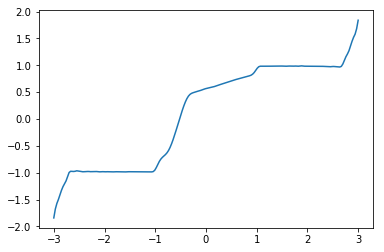

In [16]:
plt.plot(xx, vals['y_encoder'])

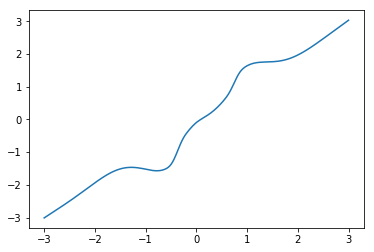

In [17]:
plt.plot(xx, vals['y_decoder'])

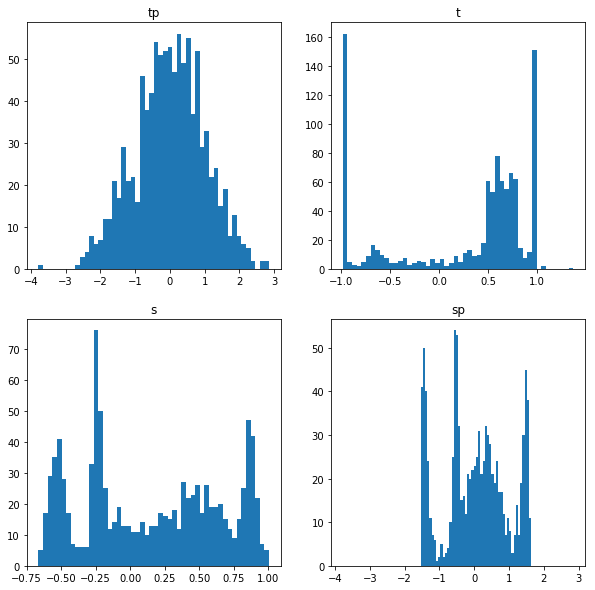

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for ax, k in zip(axes.flat, ['tp', 't', 's', 'sp']):
    ax.hist(vals[k], bins=50)
    ax.set_title(k)
#     ax.set_yscale('log')
    
_= axes[1,1].set_xlim(*(axes[0, 0].get_xlim()))

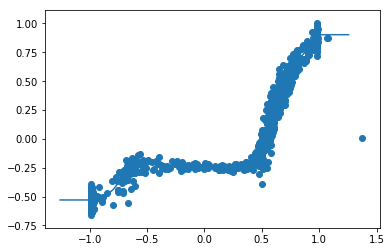

In [19]:
plt.plot(vs_data, mus_data)
plt.scatter(vals['t'], vals['s'])

(-1.75, 1.75)

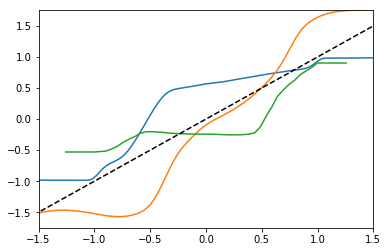

In [35]:
plt.plot(xx, vals['y_encoder'], label='f')
plt.plot(xx, vals['y_decoder'], label='h')
plt.plot(vs_data, mus_data, label='g')
plt.plot(xx, xx, 'k--', label='x')
plt.xlim(-1.5,1.5)
plt.ylim(-1.75,1.75)

In [ ]:
# x = c_[linspace(0,1,1000)]
# close('all')
# f, h = f_h(theta, n_symbols, n_devices)
# plot(x, f[0,0](x), label='f')
# plot(x, g_eval(x), label='g')
# plot(x, h[0,0](x), label='h')
# xhat = forward(x, theta, n_devices)
# plot(x, xhat, label='xhat')
# plot(x, x, 'k--', label='x')
# legend(loc='upper left')

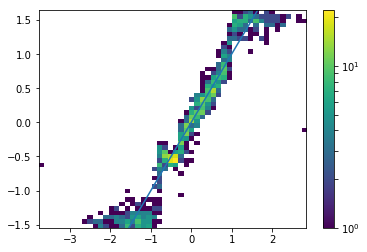

In [20]:
_ = plt.hist2d(vals['tp'].ravel(), vals['sp'].ravel(), bins=50, norm=LogNorm())
plt.plot(xx, xx)
plt.colorbar()

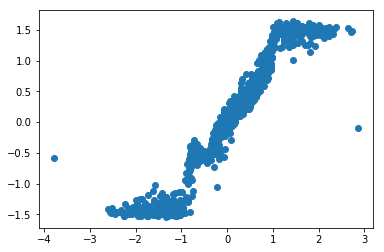

In [21]:
plt.scatter(vals['tp'].ravel(), vals['sp'].ravel())